# Import Libraries

In [1]:
%pylab inline
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional, Merge, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.metrics import mean_squared_error
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data

[S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631184400&period2=1499612400&interval=1d&filter=history&frequency=1d) 에서 1950/01/01 부터 07/07/2017년까지의 데이터를 받았습니다.<br>
테스트용으로서 Dataset전체에 대해서 standardization을 했습니다.

data_x : (16947, 190)
data_y : (16947, 1)
train_x: (13557, 190)
train_y: (13557, 1)
test_x : (3390, 190)
test_y : (3390, 1)


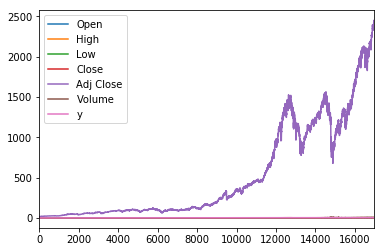

In [12]:
BATCH_SIZE = 38
LAG_SIZE = 1
TRAINING_SIZE = 400

raw_data = pd.read_csv('./GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
# raw_data = raw_data[::-1]

def preprocess(data):
    X_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume']
    Y_COLUMNS = ['y']
    COLUMNS = X_COLUMNS + Y_COLUMNS
    
    # Standardization
    scaler = StandardScaler()
    data[X_COLUMNS] = scaler.fit_transform(data[X_COLUMNS])
    
    # Create Y
    # 반드시 Standardization이후에 와야 함
    data['y'] = data.Close.shift(-1)
    data = data.dropna()
    
    # BATCH
    data = data[:data.shape[0]-data.shape[0]%BATCH_SIZE]
    data = data[COLUMNS].as_matrix()

    # Split X and Y
    N = data.shape[0]-BATCH_SIZE -1
    data_x = np.zeros((N, BATCH_SIZE, 5))
    data_y = np.zeros((N, 1))
    
    for i in range(N):
        end = i + BATCH_SIZE + 1
        series = data[i:end]
        
        data_x[i, :] = series[:BATCH_SIZE, :-1].reshape(BATCH_SIZE, 5)
        data_y[i] = series[BATCH_SIZE:, -1]
    
    data_x = data_x.reshape((-1, BATCH_SIZE*5))
    return scaler, data_x, data_y

def split_train_test(data_x, data_y, test_size=0.2):
    train_size = int(data_y.shape[0] * (1-test_size))
    
    train_x, test_x = data_x[:train_size], data_x[train_size:]
    train_y, test_y = data_y[:train_size], data_y[train_size:]
        
    return train_x, train_y, test_x, test_y
    
scaler, data_x, data_y = preprocess(raw_data)
train_x, train_y, test_x, test_y = split_train_test(data_x, data_y)

print('data_x :', data_x.shape)
print('data_y :', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)


raw_data.plot()

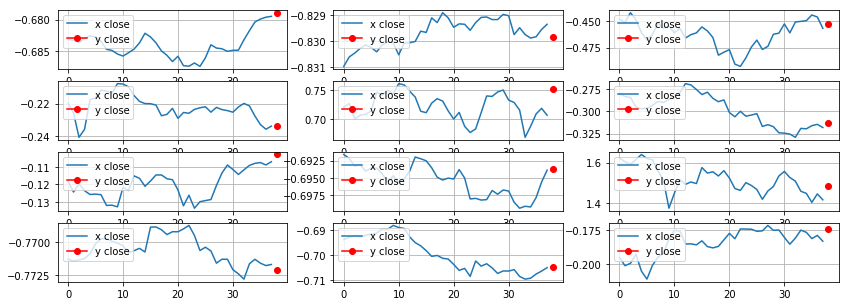

In [15]:
def visualize_data(x, y):
    f, plots = subplots(4, 3)
    f.set_figheight(5)
    f.set_figwidth(14)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(x.shape[0])
        t = np.arange(BATCH_SIZE+1)
        p.plot(t[:-1], x[idx,  np.arange(3, BATCH_SIZE*5, 5)], label="x close")
        p.plot(t[-1], y[idx], label='y close', marker='o', color='red')
        p.legend(loc='upper left')
        p.grid()
        
visualize_data(train_x, train_y)

# Model

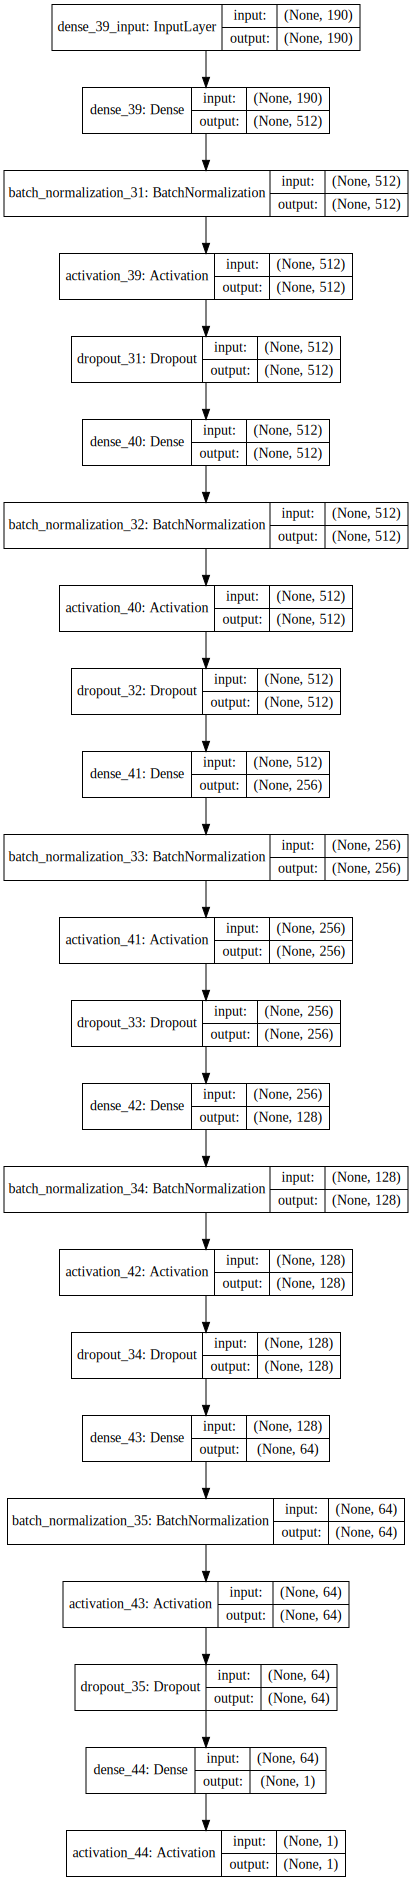

In [42]:
INPUT_N = train_x.shape[-1]
def create_model():
    model = Sequential()
    model.add(Dense(512, batch_input_shape=(None, BATCH_SIZE*5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
            
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_squared_error])
    return model
    
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [40]:
history = model.fit(train_x, train_y, verbose=2, epochs=20)

Epoch 1/20
5s - loss: 0.4497 - mean_squared_error: 0.4497
Epoch 2/20
4s - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 3/20
4s - loss: 0.0696 - mean_squared_error: 0.0696
Epoch 4/20
4s - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5/20
4s - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 6/20
4s - loss: 0.0536 - mean_squared_error: 0.0536
Epoch 7/20
4s - loss: 0.0517 - mean_squared_error: 0.0517
Epoch 8/20
4s - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 9/20
4s - loss: 0.0462 - mean_squared_error: 0.0462
Epoch 10/20
4s - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 11/20
4s - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 12/20
4s - loss: 0.0471 - mean_squared_error: 0.0471
Epoch 13/20
4s - loss: 0.0421 - mean_squared_error: 0.0421
Epoch 14/20
5s - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 15/20
4s - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 16/20
4s - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 17/20
4s - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 

TRAIN r^2 score: 0.98376613083
TRAIN MSE score: 0.00467379443494
TEST  r^2 score: 0.392815056135
TRAIN MSE score: 0.376608387793


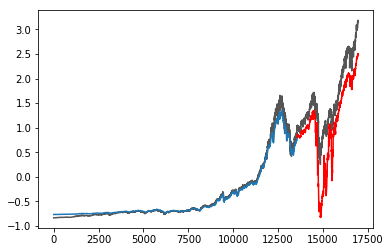

In [41]:
def validate(x_train, y_train, x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_n = y_train_pred.shape[0]
    test_n = y_test_pred.shape[0]
    x = np.arange(train_n + test_n)
    
    plot(x[:train_n], y_train, color='#555555')
    plot(x[:train_n], y_train_pred)
    
    plot(x[train_n:], y_test, color='#555555')
    plot(x[train_n:], y_test_pred, color='red')
    
    print('TRAIN r^2 score:', r2_score(y_train_pred, y_train))
    print('TRAIN MSE score:', mse(y_train_pred, y_train))
    
    print('TEST  r^2 score:', r2_score(y_test_pred, y_test))
    print('TRAIN MSE score:', mse(y_test_pred, y_test))
    
validate(train_x, train_y, test_x, test_y)

### Test 1
```
 - epoch 10
 - mse

 - LSTM 64
 - LSTM 64
 - Reshape 
 
 - 2048
 - batch
 - selu
 
 - 1280
 - batch
 - selu
 
 - 512
 - batch
 - selu
 
 - 256
 - batch
 - selu
 
 - 1
 
TRAIN r^2 score: 0.985016345938 
TRAIN MSE score: 0.00629689728654
TEST  r^2 score: -0.929616577374
TRAIN MSE score: 0.189794574429

20번 돌리면
TRAIN r^2 score: 0.987728857903
TRAIN MSE score: 0.00501801610127
TEST  r^2 score: -0.609017352468
TRAIN MSE score: 0.230812901795
```


In [270]:
def create_deep_model():
    model = Sequential()
    model.add(Dense())
#     model.add(Reshape((515166, 5,), input_shape=(BATCH_SIZE, 5)))
    
#     model.add(Reshape((BATCH_SIZE*lstm_memory,), 
#                       input_shape=(-1, BATCH_SIZE, lstm_memory)))  # (2, 1, 2432)
    return model


deep_train_x = train_x.reshape((-1, BATCH_SIZE *5))
print(deep_train_x.shape)

model = create_deep_model()
model.predict(train_x).shape

(13557, 190)


TypeError: __init__() missing 1 required positional argument: 'units'